In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
import mat73
import os
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap

In [2]:
direc='G:\\My Drive\\ActiveProjects\\Pacman__YEK__20230112_180240\\Pacman__YEK__20230112_180240\\'
trials=100
file_prefix='Pacman__YEK__20230112_180240_'


def getsessioninfo(direc,file_prefix='Pacman__YEK__20230112_180240_'):

    seshVars=loadmat(direc + file_prefix +'sessionVars.mat')
    sessionInfo={'nTrials':seshVars['sessionVars']['trialNum'][0][0][0][0]}

    taskspecs=loadmat(direc + file_prefix +'taskVariables.mat')

    sessionInfo['startpositions']=getstartpos(sessionInfo,taskspecs)

    return sessionInfo

def getstartpos(sessionInfo,taskspecs):
    '''
    Get the starting position for each session in each trial.
    :param sessionInfo:
    :param taskspecs:
    :return: startpos: column 1: x position target 1, columns 2 : y position target 1, column 3: x pos target 2, column 4: y pos target 2, etc..
    '''
    Apos=pd.DataFrame()
    Bpos=pd.DataFrame()
    Cpos=pd.DataFrame()

    for trialidx in range(sessionInfo['nTrials']):
        A=pd.DataFrame(taskspecs['pacmanTaskSpecs'][0]['taskData'][0]['startingPosition'][0][0][0][trialidx]).transpose()
        B=pd.DataFrame(taskspecs['pacmanTaskSpecs'][0]['taskData'][0]['startingPosition'][0][0][1][trialidx]).transpose()
        C=pd.DataFrame(taskspecs['pacmanTaskSpecs'][0]['taskData'][0]['startingPosition'][0][0][2][trialidx]).transpose()
        NaNFrame=pd.DataFrame(np.zeros([1,2]))*np.nan
        if not A.empty:
            Apos=pd.concat([Apos,A],axis=0)
        else:
            Apos=pd.concat([Apos,NaNFrame],axis=0)

        if not B.empty:
            Bpos=pd.concat([Bpos,B],axis=0)
        else:
            Bpos=pd.concat([Bpos,NaNFrame],axis=0)

        if not C.empty:
            Cpos=pd.concat([Cpos,C],axis=0)
        else:
            Cpos=pd.concat([Cpos,NaNFrame],axis=0)

    Apos=Apos.rename(columns={0: "startPosX_1", 1: "startPosY_1"})
    Bpos=Bpos.rename(columns={0: "startPosX_2", 1: "startPosY_2"})
    Cpos=Cpos.rename(columns={0: "startPosX_3", 1: "startPosY_3"})

    startpos=pd.concat([Apos,Bpos,Cpos],axis=1)

    return startpos

#Loop over trials and get indices of events etc.
def dataloader(direc,file_prefix='Pacman__YEK__20230112_180240_',trial=100):
    '''
    Loads the matlab style datafile from memory, assuming it is older than V7.3
    :param direc:
    :param fname:
    :return:
    '''
    return loadmat(direc + file_prefix + str(trial) +'.mat')

##### FInish specs of data loading functions #####

#Function defining the trial variables to place into a dictionary
def gettrialvars(trialdat):
    trialVars={}

    trialVars['numNPCs']=trialdat['trialData']['numNpcs'][0,0][0,0]
    trialVars['NPCTypes']=pd.DataFrame(trialdat['trialData']['npcType'][0][0][0])[0].to_list()
    trialVars['rewardValue']=trialdat['trialData']['rewardValue'][0,0][0,0] #The value received
    trialVars['rewarded']=trialdat['trialData']['rewarded'][0,0][0,0] #The value received

    trialVars['choiceMade']=trialdat['trialData']['choiceMade'][0,0][0,0] #Something about the target collided with (so the choice)

    '''%---Get Trial Start Times---%
    %ITI start should occur within ~1 frame @ 60 Hz of trialStartTime or less
    %eye data starts collecting as soon as the ITI starts
    '''
    trialVars['trialStartTime']=(trialdat['trialData']['trialStart'][0,0][0,0]) #MAtlab based recording time in seconds
    trialVars['itiStartTime']=(trialdat['trialData']['itiStart'][0,0][0,0]) # MAtlab based recording time in seconds

    '''
    Get joystick time vector: 3rd row of trialData.joystickPosition(3,:)  <-matlab convention
    %since joystick and NPC are both collected using the same data index, this
    %time vec is the same time for NPC data as well.
    '''
    trialVars['joystickTimeVec']=trialdat['trialData']['joystickPosition'][0,0][2,:]

    '''
    Get other task events not
    '''
    trialVars['waitStart']=trialdat['trialData']['waitStart'][0,0][0,0] #%when objects appear on screen
    trialVars['chaseStart']=trialdat['trialData']['choiceStart'][0,0][0,0] #%when objects and player can move
    trialVars['chaseEnd']=trialdat['trialData']['choice2feedbackStart'][0,0][0,0] #%choice 2 feedback time (short) occurs immediately after collision
    trialVars['feedbackStart']=trialdat['trialData']['feedbackStart'][0,0][0,0] #When the feedback display starts

    '''
    Get indices of events according to joystick time
    Note: these are python row indices, so a return of 0 is the 1st value
    '''
    trialVars['waitStartInd']     = np.argwhere(np.array(trialVars['joystickTimeVec'])>= trialVars['waitStart'])[0][0]
    trialVars['chaseStartInd']    = np.argwhere(np.array(trialVars['joystickTimeVec'])>=trialVars['chaseStart'])[0][0]
    trialVars['chaseEndInd']      = np.argwhere(np.array(trialVars['joystickTimeVec'])>=trialVars['chaseEnd'])[0][0]
    trialVars['feedbackStartInd'] = np.argwhere(np.array(trialVars['joystickTimeVec'])>=trialVars['feedbackStart'])[0][0]


    '''
    Get positions of joystick
    '''

    trialVars['joystickXPos']=trialdat['trialData']['joystickPosition'][0,0][0,:]
    trialVars['joystickYPos']=trialdat['trialData']['joystickPosition'][0,0][1,:]
    #pixel/second (how many samples of 16.67 == second == (1000/16.67) or the number of times 16.67 ms is in 1000 ms. Dividing the whole thing thru by 1000 converts to millisecond scale
    trialVars['joystickXVel']=(np.gradient(trialVars['joystickXPos'])*(1/16.67))*(1000/16.67)
    trialVars['joystickYVel']=(np.gradient(trialVars['joystickYPos'])*(1/16.67))*(1000/16.67)

    '''
    compute gradient for joystick
    '''
    trialVars['joystickXAccel']=np.gradient(trialVars['joystickXVel'])
    trialVars['joystickYAccel']=np.gradient(trialVars['joystickYVel'])
    '''
    Get positions of NPC
    '''
    trialVars['npcXPos']=trialdat['trialData']['npcPositionX'][0][0].T
    trialVars['npcYPos']=trialdat['trialData']['npcPositionY'][0][0].T

    '''
    Compute gradients for npcs
    '''

    trialVars['npcXVel']=(np.gradient(trialVars['npcXPos'],axis=0)*(1/16.67))*(1000/16.67)
    trialVars['npcYVel']=(np.gradient(trialVars['npcYPos'],axis=0)*(1/16.67))*(1000/16.67)
    trialVars['npcXAccel']=np.gradient(trialVars['npcXVel'],axis=0)
    trialVars['npcYAccel']=np.gradient(trialVars['npcYVel'],axis=0)


    '''
    Get tangential speed to compute RT and pointing direction towards initial target.
    '''
    trialVars=gettanspeed(trialVars)

    '''
    Do we confine to chaseStartInd:chaseEndInd?

    '''

    events=[trialVars['chaseStartInd'],trialVars['chaseEndInd']]

    trialVars=eventcuttime(events,trialVars)

    return trialVars


#Data analysis functions used in gettrialvars
def gettanspeed(trialVars):
    trialVars['npcSpeed']=np.sqrt((trialVars['npcXVel']**2)+(trialVars['npcYVel']**2))
    trialVars['joysticksSpeed']=np.sqrt((trialVars['joystickXVel']**2)+(trialVars['joystickYVel']**2))
    return trialVars



def eventcuttime(events,trialVars):
    '''

    :param events:
    :param trialVars:
    :return:
    '''

    trialVars['joystickXPos']=trialVars['joystickXPos'][events[0]:events[1]]
    trialVars['joystickYPos']=trialVars['joystickYPos'][events[0]:events[1]]
    trialVars['joystickXVel']=trialVars['joystickXVel'][events[0]:events[1]]
    trialVars['joystickYVel']=trialVars['joystickYVel'][events[0]:events[1]]
    trialVars['joystickXAccel']=trialVars['joystickXAccel'][events[0]:events[1]]
    trialVars['joystickYAccel']=trialVars['joystickYAccel'][events[0]:events[1]]

    trialVars['npcXPos']=trialVars['npcXPos'][events[0]:events[1],:]
    trialVars['npcYPos']=trialVars['npcYPos'][events[0]:events[1],:]
    trialVars['npcXVel']=trialVars['npcXVel'][events[0]:events[1],:]
    trialVars['npcYVel']=trialVars['npcYVel'][events[0]:events[1],:]
    trialVars['npcXAccel']=trialVars['npcXAccel'][events[0]:events[1],:]
    trialVars['npcYAccel']=trialVars['npcYAccel'][events[0]:events[1],:]

    return trialVars

def trialplotter(trialVars):
    '''
    Could be better if we fix the joystick time axis and add legends, but who cares right now.

    :param trialVars:
    :return:
    '''
    plt.plot(trialVars['joystickTimeVec'],trialVars['joystickXVel'])
    plt.plot(trialVars['joystickTimeVec'],trialVars['joystickYVel'])
    plt.plot(trialVars['joystickTimeVec'][1:(len(trialVars['npcXPos'])+1)],trialVars['npcXPos'][:,0])

    # only one line may be specified; full height
    plt.axvline(x = trialVars['joystickTimeVec'][trialVars['waitStartInd'] ], color = 'b', label = 'axvline - full height')
    plt.axvline(x = trialVars['joystickTimeVec'][trialVars['chaseStartInd']], color = 'g', label = 'axvline - full height')
    plt.axvline(x = trialVars['joystickTimeVec'][trialVars['chaseEndInd']], color = 'r', label = 'axvline - full height')
    plt.show()


In [3]:
seshinfo=getsessioninfo(direc,file_prefix='Pacman__YEK__20230112_180240_')
#example of loader
trialdata=dataloader(direc,file_prefix=file_prefix,trial=5)

'\nDo we confine to chaseStartInd:chaseEndInd?\n\n'

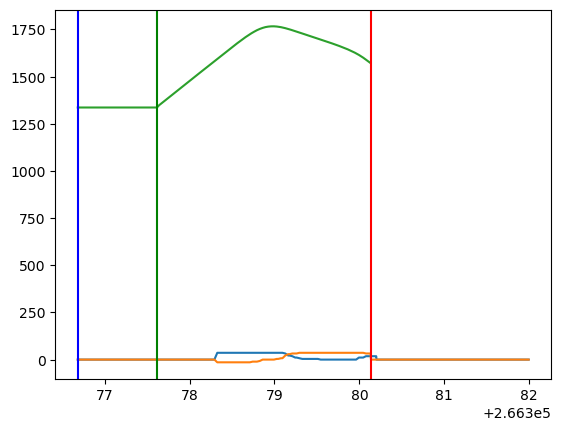

In [4]:
#Let's make a plot of behavior similar to Seth's
plt.plot(trialVars['joystickTimeVec'],trialVars['joystickXVel'])
plt.plot(trialVars['joystickTimeVec'],trialVars['joystickYVel'])
plt.plot(trialVars['joystickTimeVec'][1:(len(trialVars['npcXPos'])+1)],trialVars['npcXPos'][:,0])

# only one line may be specified; full height
plt.axvline(x = trialVars['joystickTimeVec'][waitStartInd], color = 'b', label = 'axvline - full height')
plt.axvline(x = trialVars['joystickTimeVec'][chaseStartInd], color = 'g', label = 'axvline - full height')
plt.axvline(x = trialVars['joystickTimeVec'][chaseEndInd], color = 'r', label = 'axvline - full height')

In [34]:

trialVars['npcXPos'][waitStartInd,0]



1336.0

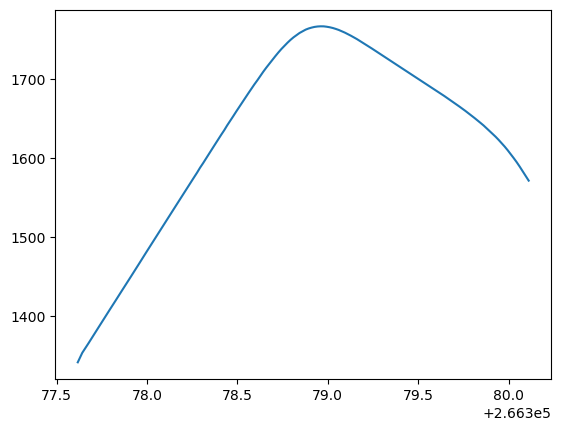

In [8]:
#Compare choice made and options available (highest reward?)
#Make psychometric plot effectively.. using 2 prey trials.

plt.plot(trialVars['joystickTimeVec'][chaseStartInd:chaseEndInd],trialVars['npcXPos'][chaseStartInd:chaseEndInd])


# only one line may be specified; full height
plt.axvline(x = trialVars['joystickTimeVec'][waitStartInd], color = 'b', label = 'axvline - full height')
plt.axvline(x = trialVars['joystickTimeVec'][chaseStartInd], color = 'g', label = 'axvline - full height')
plt.axvline(x = trialVars['joystickTimeVec'][chaseEndInd], color = 'r', label = 'axvline - full height')

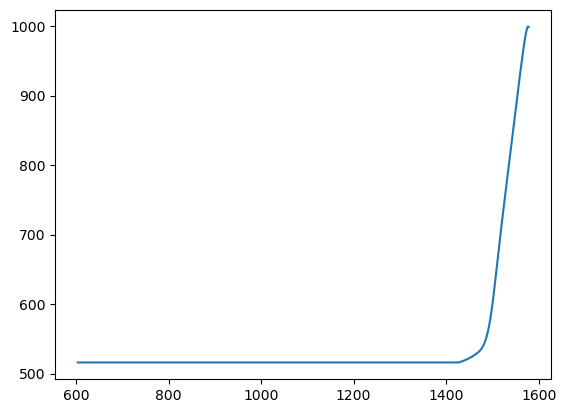

In [90]:
npcSpeed=np.sqrt((trialVars['npcXVel']**2)+(trialVars['npcYVel']**2))
plt.plot(trialVars['npcYPos'])

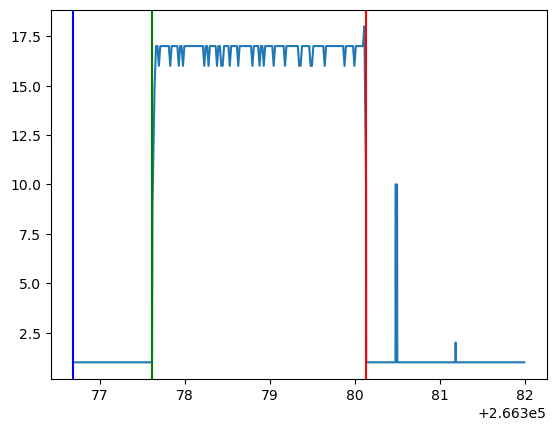

In [79]:
plt.plot(trialVars['joystickTimeVec'],np.round(np.gradient(trialVars['joystickTimeVec']),3)*1000)
plt.axvline(x = trialVars['joystickTimeVec'][waitStartInd], color = 'b', label = 'axvline - full height')
plt.axvline(x = trialVars['joystickTimeVec'][chaseStartInd], color = 'g', label = 'axvline - full height')
plt.axvline(x = trialVars['joystickTimeVec'][chaseEndInd], color = 'r', label = 'axvline - full height')

In [80]:
chaseStartInd

1428

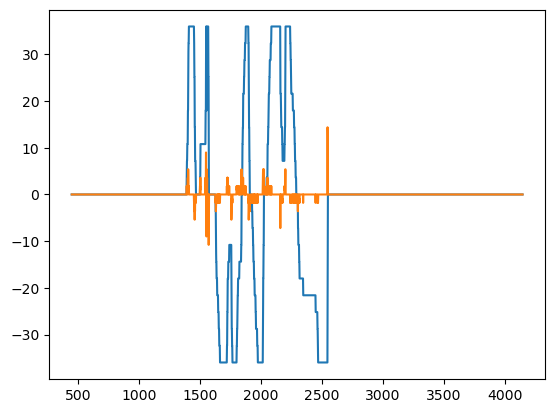

In [49]:
trialVars['joystickXVel']=((np.gradient(trialVars['joystickXPos'])*(1/16.67))*(1000/16.67))
trialVars['joystickYVel']=((np.gradient(trialVars['joystickYPos'])*(1/16.67))*(1000/16.67))
trialVars['joystickXAccel']=np.gradient(trialVars['joystickXVel'])

plt.plot(trialVars['joystickXVel'])
plt.plot(trialVars['joystickXAccel'])

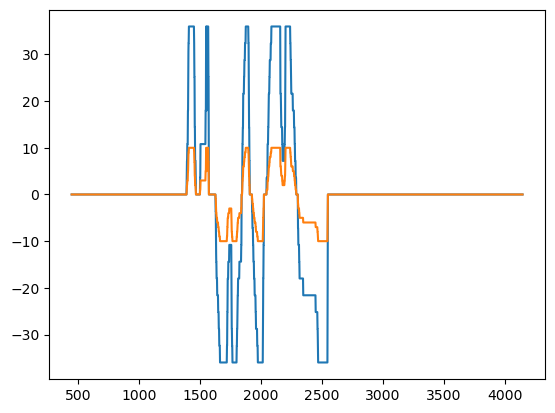

In [48]:
A=((np.gradient(trialVars['joystickXPos'])*(1/16.67))*(1000/16.67))
B=((np.gradient(trialVars['joystickXPos'])*(16.67/1000))*(1/0.01667))
plt.plot(A)
plt.plot(B)